In [6]:
# mount google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# read the data 

In [244]:
# read the data 
import pandas as pd
import numpy as np
np.random.seed(7)

train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Datasets for Machine Learning/Normalized_Data_Train_LR_NN_Factors_Stratified.csv", index_col=0)
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Datasets for Machine Learning/Normalized_Data_Test_LR_NN_Factors_Stratified.csv", index_col=0)


# data cleaning

In [245]:
# It is an imbalanced dataset
train_x = train.iloc[:, 0:11]
train_y = train.iloc[:, 11]

test_x = test.iloc[:, 0:11]
test_y = test.iloc[:, 11]


numOfPositive = np.sum(train_y[train_y == 1])
numOfNegative = train_y.shape[0] - numOfPositive

print(f"number of positive sample in the training set: {numOfPositive}")
print(f"number of negative sample in the testing set: {numOfNegative}")

# replace string with numeric value
train_x.Geography = train_x.Geography.replace({'France':0, 'Germany':1, 'Spain':2})
train_x.Gender = train_x.Gender.replace({'Male':0, 'Female':1})
train_x.drop(columns = "AgeBins", inplace = True)
test_x.Geography = test_x.Geography.replace({'France':0, 'Germany':1, 'Spain':2})
test_x.Gender = test_x.Gender.replace({'Male':0, 'Female':1})
test_x.drop(columns = "AgeBins", inplace = True)

number of positive sample in the training set: 1426
number of negative sample in the testing set: 5574


# data sampling (over-sampling)

In [246]:
from imblearn.over_sampling import SMOTENC
# from imblearn.under_sampling import RandomUnderSampler

smote = SMOTENC(categorical_features=[0,1,2,3], sampling_strategy = 1, random_state = 2020)
train_x_resampled, train_y_resampled = smote.fit_sample(train_x, train_y)
train_x_resampled = pd.DataFrame(train_x_resampled, columns=train_x.columns)
train_x_resampled = pd.concat((train_x_resampled.iloc[:,0:4].apply(pd.to_numeric,downcast = 'integer', axis = 0), train_x_resampled.iloc[:,4:10]), axis = 1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# generate dummy variable

In [247]:
# dummy variables (one hot encoding) for tree based algorithm (decision tree, random forest, XGBoost)
train_x_resampled_trees = pd.get_dummies(train_x_resampled, columns = ['Geography', "Gender", "HasCrCard", "IsActiveMember"], drop_first= False)
train_x_resampled_trees.rename(columns={"Geography_0": "Geography_France", "Geography_1": "Geography_Germany", "Geography_2": "Geography_Spain", "Gender_0": "Gender_Male", "Gender_1": "Gender_Female"}, inplace=True)
test_x_trees = pd.get_dummies(test_x, columns = ['Geography', "Gender", "HasCrCard", "IsActiveMember"], drop_first= False)
test_x_trees.rename(columns={"Geography_0": "Geography_France", "Geography_1": "Geography_Germany", "Geography_2": "Geography_Spain", "Gender_0": "Gender_Male", "Gender_1": "Gender_Female"}, inplace=True)

# dummy variables used for logistic regression, neural network
train_x_resampled = pd.get_dummies(train_x_resampled, columns = ['Geography'], drop_first= True)
train_x_resampled.rename(columns={"Geography_1": "Germany", "Geography_2": "Spain"}, inplace=True)
test_x = pd.get_dummies(test_x, columns = ['Geography'], drop_first= True)
test_x.rename(columns={"Geography_1": "Germany", "Geography_2": "Spain"}, inplace=True)

# Feature engineering



---



# logistic regression feature selection

In [125]:
from itertools import product

def plot_confusion_matrix(cm):
    fig, ax = plt.subplots()
    cmap = "coolwarm"
    im_ = ax.imshow(cm,interpolation = "nearest",cmap = "coolwarm")
    xlen, ylen = cm.shape
    thresh = (cm.max() + cm.min()) / xlen
    display_labels = (0,1)
    cmap_min, cmap_max = im_.cmap(0), im_.cmap(256)
    for i,j in product(range(xlen),range(xlen)):
        color = cmap_max if cm[i,j] < thresh else cmap_min
        ax.text(j,i,format(cm[i,j],".0f"),ha = "center",va = "center",color = "black")
    fig.colorbar(im_,ax = ax)
    ax.set(xticks = np.arange(xlen),
        yticks = np.arange(ylen),
        xticklabels = display_labels,
        yticklabels = display_labels,
        ylabel = "True label",
        xlabel = "Predicted label")
    ax.set_ylim((2 - 0.5,-0.5))
    plt.show()
    return None

Optimization terminated successfully.
         Current function value: 0.532925
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                11148
Model:                          Logit   Df Residuals:                    11136
Method:                           MLE   Df Model:                           11
Date:                Fri, 02 Oct 2020   Pseudo R-squ.:                  0.2312
Time:                        12:33:29   Log-Likelihood:                -5941.0
converged:                       True   LL-Null:                       -7727.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5513      0.060     -9.231      0.000      -0.668      -0.434
Gender        

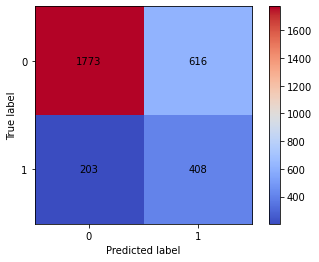

Accuracy:
72.70%

Classification report:
              precision    recall  f1-score   support

         0.0       0.90      0.74      0.81      2389
         1.0       0.40      0.67      0.50       611

    accuracy                           0.73      3000
   macro avg       0.65      0.70      0.66      3000
weighted avg       0.80      0.73      0.75      3000



In [131]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
import matplotlib.pyplot as plt


y_train = train_y_resampled.astype(float)
X_train = train_x_resampled.astype(float)
X_train.insert(0,"const",1)

y_test = test_y.astype(float)
X_test = test_x.astype(float)
X_test.insert(0,"const",1)

logit = sm.Logit(y_train, X_train)
full_model = logit.fit()
print(full_model.summary())
print()

prob_full_model = full_model.predict(X_test)
pred_full_model = [0 if x < 0.5 else 1 for x in prob_full_model]

print("Confusion matrix:")
plot_confusion_matrix(confusion_matrix(list(y_test),pred_full_model))
print("Accuracy:")
print("{0:.2f}%".format(accuracy_score(list(y_test),pred_full_model) * 100))
print()
print("Classification report:")
print(classification_report(list(y_test),pred_full_model))

# decision tree feature selection

In [219]:
from sklearn.tree import DecisionTreeClassifier

path = DecisionTreeClassifier(criterion = "gini",random_state = 2020).cost_complexity_pruning_path(train_x_resampled_trees,train_y_resampled)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print("Cost complexity pruning alphas:")
print(ccp_alphas)

Cost complexity pruning alphas:
[0.00000000e+00 5.48180042e-05 5.64791559e-05 5.68113862e-05
 5.78080772e-05 5.78080772e-05 5.79326636e-05 5.79892937e-05
 5.82680884e-05 5.84107275e-05 5.85555954e-05 5.89220259e-05
 5.93484178e-05 5.94027828e-05 5.95408863e-05 6.72766416e-05
 6.72766416e-05 6.72766416e-05 6.72766416e-05 6.82611778e-05
 6.95871525e-05 6.98662746e-05 7.05137205e-05 7.17617510e-05
 7.17617510e-05 7.17617510e-05 7.17617510e-05 7.17617510e-05
 7.17617510e-05 7.47518239e-05 7.47518239e-05 7.47877073e-05
 7.67452059e-05 7.68875903e-05 7.68875903e-05 7.77418969e-05
 7.84775246e-05 7.84894151e-05 7.84894151e-05 7.84894151e-05
 7.93519362e-05 7.97352789e-05 7.97352789e-05 7.97352789e-05
 8.07319699e-05 8.07319699e-05 8.07319699e-05 8.07319699e-05
 8.07319699e-05 8.07319699e-05 8.07319699e-05 8.07319699e-05
 8.15474443e-05 8.15474443e-05 8.15474443e-05 8.15474443e-05
 8.15474443e-05 8.21687582e-05 8.22270063e-05 8.22270063e-05
 8.22270063e-05 8.22270063e-05 8.22270063e-05 8.22270

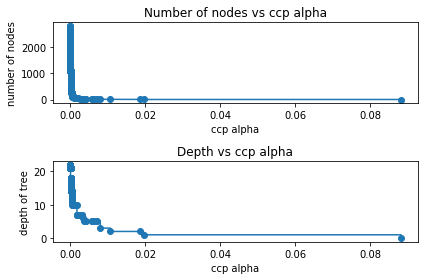

In [220]:
paths = []
for ccp_alpha in ccp_alphas:
    path = DecisionTreeClassifier(criterion = "gini",random_state = 2020,ccp_alpha = ccp_alpha)
    path.fit(train_x_resampled_trees,train_y_resampled)
    paths.append(path)

node_counts = [path.tree_.node_count for path in paths]
depth = [path.tree_.max_depth for path in paths]
fig, ax = plt.subplots(2,1)
ax[0].plot(ccp_alphas,node_counts,marker = "o",drawstyle = "steps-post")
ax[0].set_xlabel("ccp alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs ccp alpha")
ax[1].plot(ccp_alphas,depth,marker = "o",drawstyle = "steps-post")
ax[1].set_xlabel("ccp alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs ccp alpha")
fig.tight_layout();
plt.show()

Optimal cost complexity pruning alpha: 0.00023665206282988123
Minimum average cross validation error: 0.1597541280562913



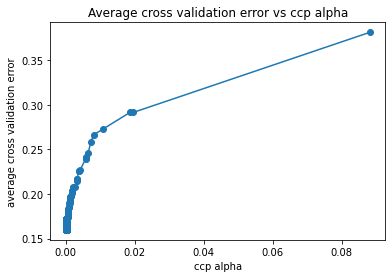

In [221]:
from sklearn.model_selection import cross_val_score

parameter_scores = []
for ccp_alpha in ccp_alphas:
    decision_tree_model_cv = DecisionTreeClassifier(criterion = "gini",random_state = 2020,ccp_alpha = ccp_alpha)
    scores = 1 - cross_val_score(decision_tree_model_cv,train_x_resampled_trees,train_y_resampled,cv = 10,scoring = "accuracy") 
    parameter_scores.append(scores.mean())
cross_validation_score_optimal = min(parameter_scores)
optimal_parameter = ccp_alphas[parameter_scores.index(min(parameter_scores))]
print("Optimal cost complexity pruning alpha:",optimal_parameter)
print("Minimum average cross validation error:",cross_validation_score_optimal)
print()
plt.plot(ccp_alphas,parameter_scores,marker = "o")
plt.xlabel("ccp alpha")
plt.ylabel("average cross validation error")
plt.title("Average cross validation error vs ccp alpha")
plt.show()

Confusion matrix:


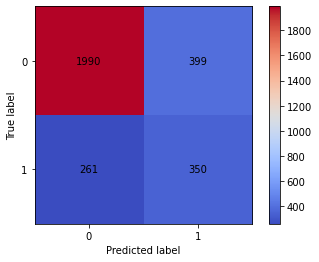

Accuracy:
78.00%

Classification report:
              precision    recall  f1-score   support

         0.0       0.88      0.83      0.86      2389
         1.0       0.47      0.57      0.51       611

    accuracy                           0.78      3000
   macro avg       0.68      0.70      0.69      3000
weighted avg       0.80      0.78      0.79      3000



In [254]:
pruned_decision_tree = DecisionTreeClassifier(criterion = "gini",random_state = 2020,ccp_alpha = optimal_parameter)
pruned_decision_tree.fit(train_x_resampled_trees,train_y_resampled)
pred_pruned_tree = pruned_decision_tree.predict(test_x_trees)

print("Confusion matrix:")
plot_confusion_matrix(confusion_matrix(y_test,pred_pruned_tree,labels = [0,1]))
print("Accuracy:")
print("{0:.2f}%".format(accuracy_score(y_test,pred_pruned_tree) * 100))
print()
print("Classification report:")
print(classification_report(y_test,pred_pruned_tree))

In [255]:
pruned_decision_tree = DecisionTreeClassifier(criterion = "gini",random_state = 2020,ccp_alpha = ccp_alphas[parameter_scores.index(min(parameter_scores))])
pruned_decision_tree.fit(X_train,y_train)
feat_importance = list(pruned_decision_tree.tree_.compute_feature_importances(normalize = True))
feat_list = ['CreditScore', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts',
             'Age', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 
             'Gender_Female', 'Gender_Male', 'HasCrCard_0', 'HasCrCard_1', 'IsActiveMember_0', 'IsActiveMember_1']
importance = feat_importance * 100
df = pd.DataFrame({"Feature": ['CreditScore', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts',
                               'Age', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember'],
                   "Importance": [importance[0], importance[1], importance[2], importance[3], importance[4], 
                                  importance[5], (importance[6]+importance[7]+importance[8]), (importance[9]+importance[10]),
                                  (importance[11]+importance[12]), (importance[13]+importance[14])]})
df

,Feature,Importance
0,CreditScore,0.052210
1,Balance,0.113588
2,EstimatedSalary,0.067107
3,Tenure,0.059687
4,NumOfProducts,0.129473
5,Age,0.388084
6,Geography,0.086218
7,Gender,0.018884
8,HasCrCard,0.008180
9,IsActiveMember,0.076568


# mutual information feature selection (univariate feature selection)

In [143]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

##########Univariate feature selection
columns = train_x_resampled.columns
print("------------univariate feature selection------------")
sk = SelectKBest(mutual_info_classif, k=9)
sk.fit(train_x_resampled, train_y_resampled)

feature_removed = columns[[not x for x in sk.get_support()]]
print(f"\nfeature removed: {feature_removed}")

for i in range(len(sk.scores_)):
  print(f"{columns[i]}: {sk.scores_[i]}")

------------univariate feature selection------------

feature removed: Index(['HasCrCard', 'EstimatedSalary'], dtype='object')
Gender: 0.011742150000696672
HasCrCard: 0.005631925332518772
IsActiveMember: 0.037850831342780555
CreditScore: 0.26220278890049764
Balance: 0.033927764579053
EstimatedSalary: 0.006075102636281304
Tenure: 0.23319736699177396
NumOfProducts: 0.09422055136271612
Age: 0.37628919854324927
Germany: 0.04275404895590196
Spain: 0.015546200929531517


# Feature selection final decision

In [248]:
# based on previous three feature selection methods
# we finally deceide to remove 'HasCrCard', 'EstimatedSalary', 'CreditScore'

train_x_resampled_selected = train_x_resampled.loc[:,['Gender','IsActiveMember', 'Balance','Tenure', 
                                                      'NumOfProducts', 'Age', 'Germany','Spain']]
test_x_selected = test_x.loc[:,['Gender','IsActiveMember', 'Balance','Tenure', 
                                  'NumOfProducts', 'Age', 'Germany','Spain']]

train_x_resampled_trees_selected = train_x_resampled_trees.loc[:,['Balance',  'Tenure', 'NumOfProducts',
                                                                  'Age', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 
                                                                  'Gender_Female', 'Gender_Male', 'IsActiveMember_0', 'IsActiveMember_1']]
test_x_trees_selected = test_x_trees.loc[:,['Balance',  'Tenure', 'NumOfProducts',
                                            'Age', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 
                                            'Gender_Female', 'Gender_Male', 'IsActiveMember_0', 'IsActiveMember_1']]



# define ROC curve

In [250]:
# draw ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


def plot_roc_curve(test_y, probs):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(test_y))]
    # calculate scores
    ns_auc = roc_auc_score(test_y, ns_probs)
    auc = roc_auc_score(test_y, probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
    fpr, tpr, _ = roc_curve(test_y, probs)

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, linestyle='--', label='Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.legend()
    # show the plot
    plt.show()

# Model Training

# SVM

Confusion matrix:


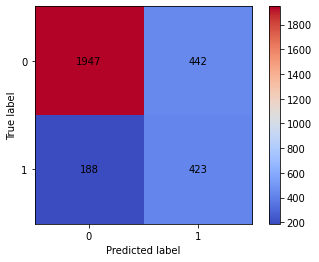

Accuracy:
79.00%
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      2389
           1       0.40      0.67      0.50       611

    accuracy                           0.73      3000
   macro avg       0.65      0.70      0.66      3000
weighted avg       0.80      0.73      0.75      3000

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.835


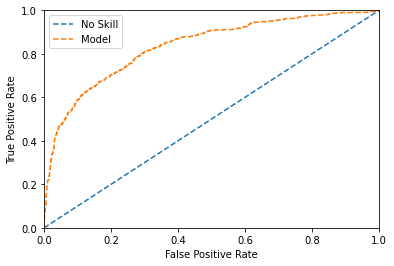

In [156]:
from sklearn.svm import SVC
svc = SVC(kernel="rbf", probability=True, random_state = 2020)
svc.fit(train_x_resampled_selected, train_y_resampled)

test_pred = svc.predict(test_x_selected)


print("Confusion matrix:")
plot_confusion_matrix(confusion_matrix(test_y,test_pred))
print("Accuracy:")
print("{0:.2f}%".format(accuracy_score(test_y,test_pred) * 100))
print("Classification report:")
print(classification_report(test_y,pred_full_model))
# predict probabilities
svc_probs = svc.predict_proba(test_x_selected)
# keep for the positive outcome only
svc_probs = svc_probs[:,1]
plot_roc_curve(test_y, svc_probs)

# Artificial Neural Network (ANN)

Epoch 1/100
175/175 [==============================] - 0s 1ms/step - loss: 0.7043 - auc: 0.5580
Epoch 2/100
175/175 [==============================] - 0s 1ms/step - loss: 0.6102 - auc: 0.7341
Epoch 3/100
175/175 [==============================] - 0s 1ms/step - loss: 0.5495 - auc: 0.8000
Epoch 4/100
175/175 [==============================] - 0s 1ms/step - loss: 0.5192 - auc: 0.8214
Epoch 5/100
175/175 [==============================] - 0s 1ms/step - loss: 0.4978 - auc: 0.8388
Epoch 6/100
175/175 [==============================] - 0s 1ms/step - loss: 0.4928 - auc: 0.8416
Epoch 7/100
175/175 [==============================] - 0s 1ms/step - loss: 0.4839 - auc: 0.8473
Epoch 8/100
175/175 [==============================] - 0s 1ms/step - loss: 0.4790 - auc: 0.8510
Epoch 9/100
175/175 [==============================] - 0s 2ms/step - loss: 0.4740 - auc: 0.8547
Epoch 10/100
175/175 [==============================] - 0s 1ms/step - loss: 0.4697 - auc: 0.8574
Epoch 11/100
175/175 [=================

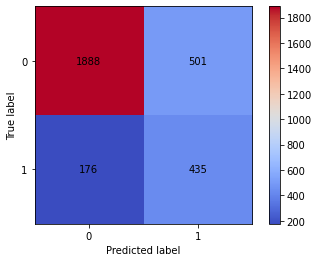

Accuracy:
77.43%
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      2389
           1       0.46      0.71      0.56       611

    accuracy                           0.77      3000
   macro avg       0.69      0.75      0.71      3000
weighted avg       0.82      0.77      0.79      3000

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.841


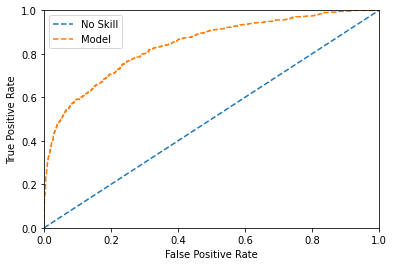

In [169]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from numpy.random import seed
from tensorflow.random import set_seed
seed(0)
set_seed(0)



model = Sequential()
model.add(Dense(12, kernel_initializer = 'he_uniform',activation='relu',input_dim = 8))
model.add(Dropout(0.1))
model.add(Dense(6, kernel_initializer = 'he_uniform',activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['AUC'])
# Fit the model
model.fit(train_x_resampled_selected, train_y_resampled, epochs=100, batch_size = 64)
# evaluate the model

predictions = model.predict(test_x_selected)

print("Confusion matrix:")
plot_confusion_matrix(confusion_matrix(test_y,(predictions > 0.5)*1))
print("Accuracy:")
print("{0:.2f}%".format(accuracy_score(test_y,(predictions > 0.5)*1) * 100))
print("Classification report:")
print(classification_report(test_y,(predictions > 0.5)*1))

#evaluate the result
plot_roc_curve(test_y, predictions)



# Random Forest

In [251]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 22)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
#The function to measure the quality of a split.
criterion = ['gini', 'entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
print(random_grid)




# initialize the model 
rf = RandomForestClassifier()
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, scoring = 'roc_auc', cv = 3, verbose=2, random_state=2020)
# Fit the random search model
rf_random.fit(train_x_resampled_trees_selected, train_y_resampled)

print(rf_random.best_params_)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['log2', 'sqrt', None], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True], 'criterion': ['gini', 'entropy']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=55, criterion=entropy, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=55, criterion=entropy, bootstrap=True, total=   7.2s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=55, criterion=entropy, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=55, criterion=entropy, bootstrap=True, total=   6.8s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=55, criterion=entropy, bootstrap=True 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=55, criterion=entropy, bootstrap=True, total=   6.8s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=25, criterion=entropy, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=25, criterion=entropy, bootstrap=True, total=   5.2s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=25, criterion=entropy, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=25, criterion=entropy, bootstrap=True, total=   4.9s
[CV] n_es

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 29.8min finished


{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 85, 'criterion': 'entropy', 'bootstrap': True}


Confusion matrix:


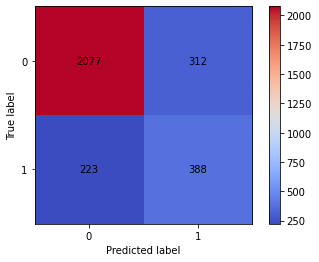

Accuracy:
82.17%
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2389
           1       0.55      0.64      0.59       611

    accuracy                           0.82      3000
   macro avg       0.73      0.75      0.74      3000
weighted avg       0.83      0.82      0.83      3000

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.836


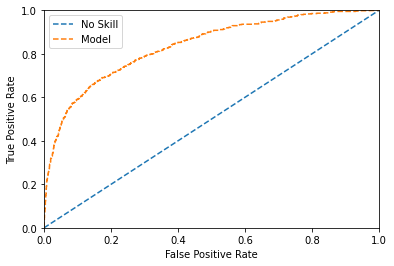

In [257]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 500, min_samples_split = 5, min_samples_leaf = 1, max_features = 'auto', 
                            max_depth = 86, criterion =  'entropy', bootstrap = True, random_state = 2020)
rf.fit(train_x_resampled_trees_selected, train_y_resampled)
test_pred = rf.predict(test_x_trees_selected)

print("Confusion matrix:")
plot_confusion_matrix(confusion_matrix(test_y,test_pred))
print("Accuracy:")
print("{0:.2f}%".format(accuracy_score(test_y,test_pred) * 100))
print("Classification report:")
print(classification_report(test_y,test_pred))

# predict probabilities
rf_probs = rf.predict_proba(test_x_trees_selected)
# keep for the positive outcome only
rf_probs = rf_probs[:,1]
plot_roc_curve(test_y, rf_probs)


# XGBoost

In [258]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 20, num = 16)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 22)]
max_depth.append(None)
# learning rate
learning_rate = [0.001, 0.01, 0.1, 1]
# minimum child weight
min_child_weight = [1,2,3]
# set gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree
gamma = [round(x,2) for x in np.linspace(0, 2, num = 21)]
# Maximum delta step we allow each leaf output to be. If the value is set to 0, it means there is no constraint.
max_delta_step = [int(x) for x in np.linspace(start=0, stop=10, num=11)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'learning_rate': learning_rate,
               'min_child_weight':min_child_weight,
              #  'gamma': gamma,
               'max_delta_step' : max_delta_step 
               }
print(random_grid)




# initialize the model 
xgb = XGBClassifier()
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, scoring = 'roc_auc', n_iter = 100, cv = 3, verbose=2, random_state=2020)
# Fit the random search model
#xgb_random.fit(train_x_selected.to_numpy(), train_y)
xgb_random.fit(train_x_resampled_trees_selected, train_y_resampled)
print(xgb_random.best_params_)

{'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, None], 'learning_rate': [0.001, 0.01, 0.1, 1], 'min_child_weight': [1, 2, 3], 'max_delta_step': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=5, min_child_weight=2, max_depth=105, max_delta_step=4, learning_rate=1 
[CV]  n_estimators=5, min_child_weight=2, max_depth=105, max_delta_step=4, learning_rate=1, total=   0.1s
[CV] n_estimators=5, min_child_weight=2, max_depth=105, max_delta_step=4, learning_rate=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  n_estimators=5, min_child_weight=2, max_depth=105, max_delta_step=4, learning_rate=1, total=   0.1s
[CV] n_estimators=5, min_child_weight=2, max_depth=105, max_delta_step=4, learning_rate=1 
[CV]  n_estimators=5, min_child_weight=2, max_depth=105, max_delta_step=4, learning_rate=1, total=   0.2s
[CV] n_estimators=8, min_child_weight=3, max_depth=55, max_delta_step=3, learning_rate=1 
[CV]  n_estimators=8, min_child_weight=3, max_depth=55, max_delta_step=3, learning_rate=1, total=   0.2s
[CV] n_estimators=8, min_child_weight=3, max_depth=55, max_delta_step=3, learning_rate=1 
[CV]  n_estimators=8, min_child_weight=3, max_depth=55, max_delta_step=3, learning_rate=1, total=   0.2s
[CV] n_estimators=8, min_child_weight=3, max_depth=55, max_delta_step=3, learning_rate=1 
[CV]  n_estimators=8, min_child_weight=3, max_depth=55, max_delta_step=3, learning_rate=1, total=   0.2s
[CV] n_estimators=11, min_child_weight=2, max_depth=30, max_delta_step=10, learning_rate=1 
[CV]  n_estimators=1

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[CV]  n_estimators=19, min_child_weight=3, max_depth=60, max_delta_step=3, learning_rate=1, total=   0.4s
[CV] n_estimators=19, min_child_weight=3, max_depth=60, max_delta_step=3, learning_rate=1 
[CV]  n_estimators=19, min_child_weight=3, max_depth=60, max_delta_step=3, learning_rate=1, total=   0.4s
[CV] n_estimators=19, min_child_weight=3, max_depth=60, max_delta_step=3, learning_rate=1 
[CV]  n_estimators=19, min_child_weight=3, max_depth=60, max_delta_step=3, learning_rate=1, total=   0.4s
[CV] n_estimators=11, min_child_weight=3, max_depth=15, max_delta_step=5, learning_rate=0.1 
[CV]  n_estimators=11, min_child_weight=3, max_depth=15, max_delta_step=5, learning_rate=0.1, total=   0.2s
[CV] n_estimators=11, min_child_weight=3, max_depth=15, max_delta_step=5, learning_rate=0.1 
[CV]  n_estimators=11, min_child_weight=3, max_depth=15, max_delta_step=5, learning_rate=0.1, total=   0.2s
[CV] n_estimators=11, min_child_weight=3, max_depth=15, max_delta_step=5, learning_rate=0.1 
[CV] 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[CV]  n_estimators=10, min_child_weight=1, max_depth=5, max_delta_step=10, learning_rate=0.001, total=   0.1s
[CV] n_estimators=10, min_child_weight=1, max_depth=5, max_delta_step=10, learning_rate=0.001 
[CV]  n_estimators=10, min_child_weight=1, max_depth=5, max_delta_step=10, learning_rate=0.001, total=   0.1s
[CV] n_estimators=5, min_child_weight=1, max_depth=35, max_delta_step=8, learning_rate=0.01 
[CV]  n_estimators=5, min_child_weight=1, max_depth=35, max_delta_step=8, learning_rate=0.01, total=   0.1s
[CV] n_estimators=5, min_child_weight=1, max_depth=35, max_delta_step=8, learning_rate=0.01 
[CV]  n_estimators=5, min_child_weight=1, max_depth=35, max_delta_step=8, learning_rate=0.01, total=   0.1s
[CV] n_estimators=5, min_child_weight=1, max_depth=35, max_delta_step=8, learning_rate=0.01 
[CV]  n_estimators=5, min_child_weight=1, max_depth=35, max_delta_step=8, learning_rate=0.01, total=   0.1s
[CV] n_estimators=12, min_child_weight=1, max_depth=100, max_delta_step=2, learnin

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.2min finished


{'n_estimators': 10, 'min_child_weight': 2, 'max_depth': 10, 'max_delta_step': 3, 'learning_rate': 1}


Confusion matrix:


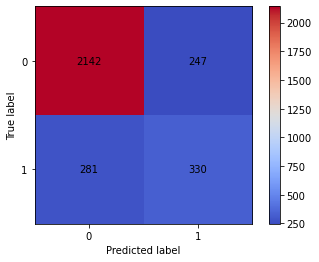

Accuracy:
82.40%
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2389
           1       0.57      0.54      0.56       611

    accuracy                           0.82      3000
   macro avg       0.73      0.72      0.72      3000
weighted avg       0.82      0.82      0.82      3000

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.819


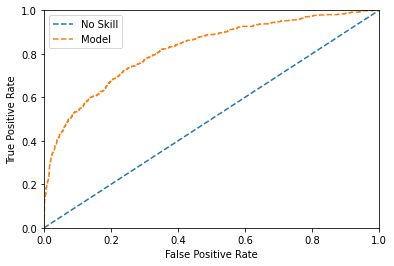

In [261]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators = 10, min_child_weight = 2, max_delta_step = 3, 
                    max_depth = 10, learning_rate = 1, random_state = 2020)
xgb.fit(train_x_resampled_trees_selected, train_y_resampled)
#xgb.fit(train_x_selected,train_y)
test_pred = xgb.predict(test_x_trees_selected)

print("Confusion matrix:")
plot_confusion_matrix(confusion_matrix(test_y,test_pred))
print("Accuracy:")
print("{0:.2f}%".format(accuracy_score(test_y,test_pred) * 100))
print("Classification report:")
print(classification_report(test_y,test_pred))
# predict probabilities
xgb_probs = xgb.predict_proba(test_x_trees_selected)
# keep for the positive outcome only
xgb_probs = xgb_probs[:,1]
plot_roc_curve(test_y, xgb_probs)
